# Energy Demand and Renewable Generation Forecasting - Timeseries Data Forecasting

This project provides a comprehensive comparison of time series forecasting techniques — including **ARIMA**, **SARIMA** and **Facebook Prophet** — using real-world energy data. It includes:

* Data preprocessing
* Forecasting with ARIMA, SARIMA and Prophet
* Visualization of predictions
* Model evaluation and comparison

## 📦 1. Import Required Libraries

In [61]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Time Series Decomposition & Analysis ---
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# --- Forecasting Models ---
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# --- Evaluation Metrics ---
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

## 2. Load & Inspect Data

**Data Source Link:** [opsd-time_series-2020-10-06](https://data.open-power-system-data.org/time_series/)

In [ ]:
file_path = r""
df = pd.read_csv(file_path, parse_dates=["utc_timestamp"])

df = df.set_index('utc_timestamp')
df.index = df.index.tz_localize(None)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50401 entries, 2014-12-31 23:00:00 to 2020-09-30 23:00:00
Columns: 299 entries, cet_cest_timestamp to UA_load_forecast_entsoe_transparency
dtypes: float64(298), object(1)
memory usage: 115.4+ MB
None


In [63]:
# Infer the frequency and set it if possible
inferred_freq = pd.infer_freq(df.index)
if inferred_freq:
    df.index.freq = inferred_freq
    print(f"Inferred frequency: {df.index.freq}")
else:
    print("Could not reliably infer the frequency of the data. Please set it manually if known.")


Inferred frequency: <Hour>


In [64]:
print("\nMissing values: ")
df.isnull().sum().head()


Missing values: 


cet_cest_timestamp                          0
AT_load_actual_entsoe_transparency          1
AT_load_forecast_entsoe_transparency        1
AT_price_day_ahead                      17556
AT_solar_generation_actual                 62
dtype: int64

In [65]:
at_cols = [col for col in df.columns if col.startswith("AT_")]
df = df[at_cols]
df.shape

(50401, 5)

In [66]:
df.head()

AT_load_actual_entsoe_transparency  \
utc_timestamp                                             
2014-12-31 23:00:00                                 NaN   
2015-01-01 00:00:00                              5946.0   
2015-01-01 01:00:00                              5726.0   
2015-01-01 02:00:00                              5347.0   
2015-01-01 03:00:00                              5249.0   

                     AT_load_forecast_entsoe_transparency  AT_price_day_ahead  \
utc_timestamp                                                                   
2014-12-31 23:00:00                                   NaN                 NaN   
2015-01-01 00:00:00                                6701.0                35.0   
2015-01-01 01:00:00                                6593.0                45.0   
2015-01-01 02:00:00                                6482.0                41.0   
2015-01-01 03:00:00                                6454.0                38.0   

                     AT_solar_generation_actual  \
utc_timestamp                                     
2014-12-31 23:00:00                         NaN   
2015-01-01 00:00:00                         NaN   
2015-01-01 01:00:00                         NaN   
2015-01-01 02:00:00                         NaN   
2015-01-01 03:00:00                         NaN   

                     AT_wind_onshore_generation_actual  
utc_timestamp                                           
2014-12-31 23:00:00                                NaN  
2015-01-01 00:00:00                               69.0  
2015-01-01 01:00:00                               64.0  
2015-01-01 02:00:00                               65.0  
2015-01-01 03:00:00                               64.0

## 3. Data Preprocessing

In [67]:
# Handle missing values
df['AT_solar_generation_actual'] = df['AT_solar_generation_actual'].fillna(0)
df = df.ffill()  # Forward fill other missing values

# Create time features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# Select target variable
target = 'AT_load_actual_entsoe_transparency'
ts = df[target]
ts.shape

(50401,)

In [68]:
ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 50401 entries, 2014-12-31 23:00:00 to 2020-09-30 23:00:00
Freq: h
Series name: AT_load_actual_entsoe_transparency
Non-Null Count  Dtype  
--------------  -----  
50400 non-null  float64
dtypes: float64(1)
memory usage: 787.5 KB


## 4. Exploratory Data Analysis

In [69]:
# Basic statistics
df.describe()

AT_load_actual_entsoe_transparency  \
count                        50400.000000   
mean                          7070.148631   
std                           1400.263167   
min                            664.000000   
25%                           5941.000000   
50%                           7032.000000   
75%                           8079.000000   
max                          10803.000000   

       AT_load_forecast_entsoe_transparency  AT_price_day_ahead  \
count                          50400.000000        50400.000000   
mean                            7039.848552           43.674663   
std                             1355.382837           18.006174   
min                             3739.000000          -76.000000   
25%                             5941.000000           29.000000   
50%                             7018.000000           42.000000   
75%                             7986.000000           62.000000   
max                            11608.000000          187.000000   

       AT_solar_generation_actual  AT_wind_onshore_generation_actual  \
count                50401.000000                       50400.000000   
mean                   135.113708                         729.300258   
std                    198.889502                         691.767878   
min                      0.000000                           0.000000   
25%                      0.000000                         163.000000   
50%                     17.000000                         492.000000   
75%                    224.000000                        1140.000000   
max                   1166.000000                        2969.000000   

               hour   day_of_week         month  
count  50401.000000  50401.000000  50401.000000  
mean      11.500228      2.999980      6.325827  
std        6.922376      2.000005      3.386848  
min        0.000000      0.000000      1.000000  
25%        6.000000      1.000000      3.000000  
50%       12.000000      3.000000      6.000000  
75%       18.000000      5.000000      9.000000  
max       23.000000      6.000000     12.000000

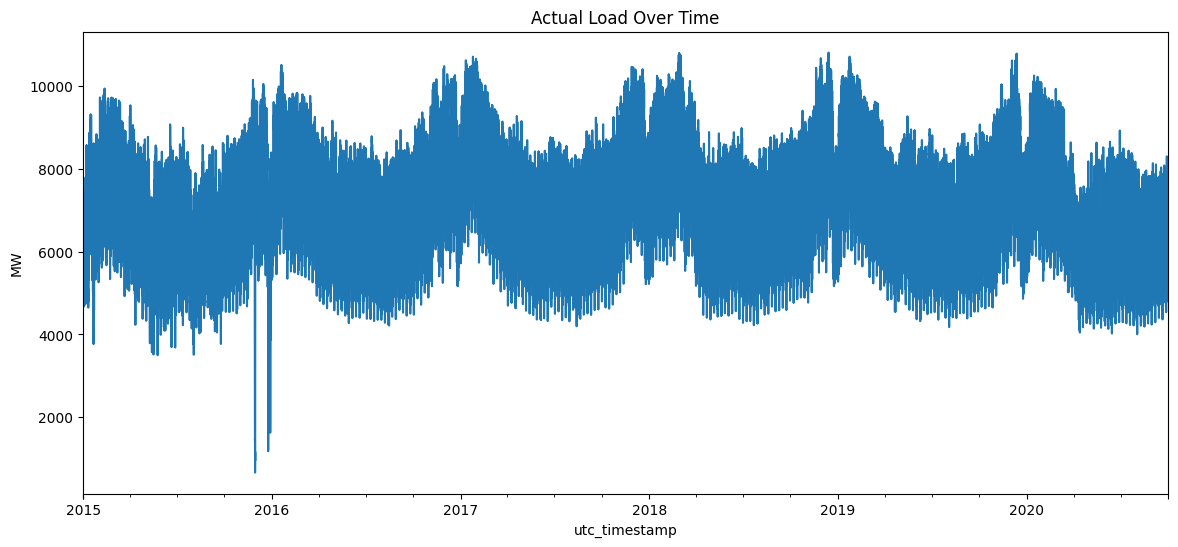

In [70]:
# Time series plot
plt.figure(figsize=(14,6))
ts.plot(title='Actual Load Over Time')
plt.ylabel('MW')
plt.show()

In [71]:
ts = ts.interpolate(method='linear')
ts = ts.dropna()
print("Missing Values: ", ts.isnull().sum())  # Count the total number of NaNs
print(ts[ts.isnull()])

Missing Values:  0
Series([], Freq: h, Name: AT_load_actual_entsoe_transparency, dtype: float64)


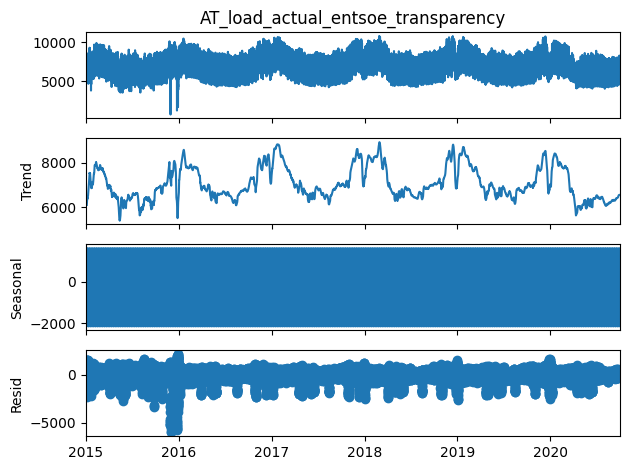

In [72]:
# Decomposition
result = seasonal_decompose(ts, period=24*7)  # Weekly seasonality
result.plot()
plt.show()

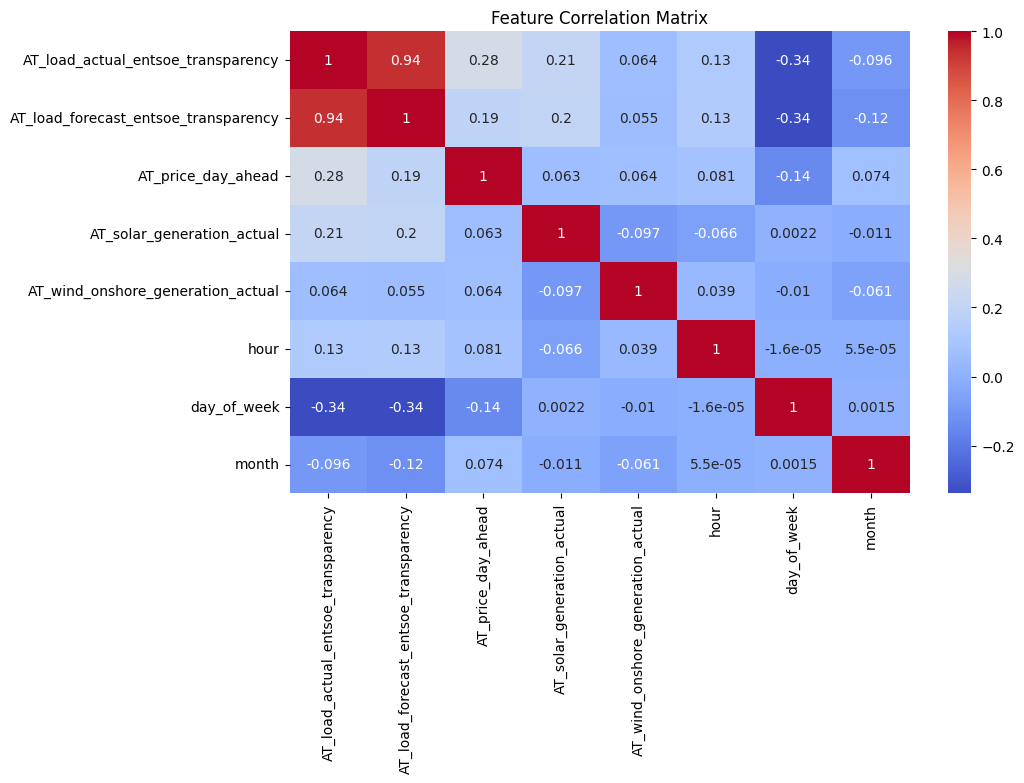

In [73]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

## 5. Time Series Analysis

ADF Statistic: -16.678007641769504
p-value: 1.524895598250756e-29


<Figure size 1400x600 with 0 Axes>

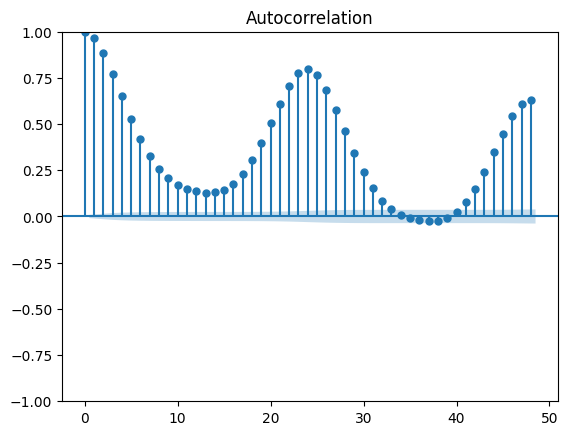

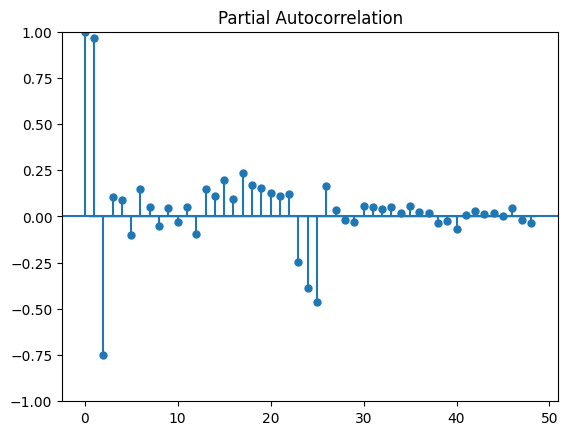

In [74]:
# Stationarity check
def test_stationarity(timeseries):
    # Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', dftest[0])
    print('p-value:', dftest[1])
    
test_stationarity(ts)

# ACF/PACF plots
plt.figure(figsize=(14,6))
plot_acf(ts, lags=48)
plot_pacf(ts, lags=48)
plt.show()

## 6. Forecasting with ARIMA

In [75]:
# Train-test split
train = ts['2015-01-01':'2015-02-10']
test = ts['2015-02-11':'2015-02-20']

In [76]:
# Fit ARIMA
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate
print(f'MAE: {mean_absolute_error(test, forecast)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, forecast))}')

MAE: 954.3637079069828
RMSE: 1110.9072865796154


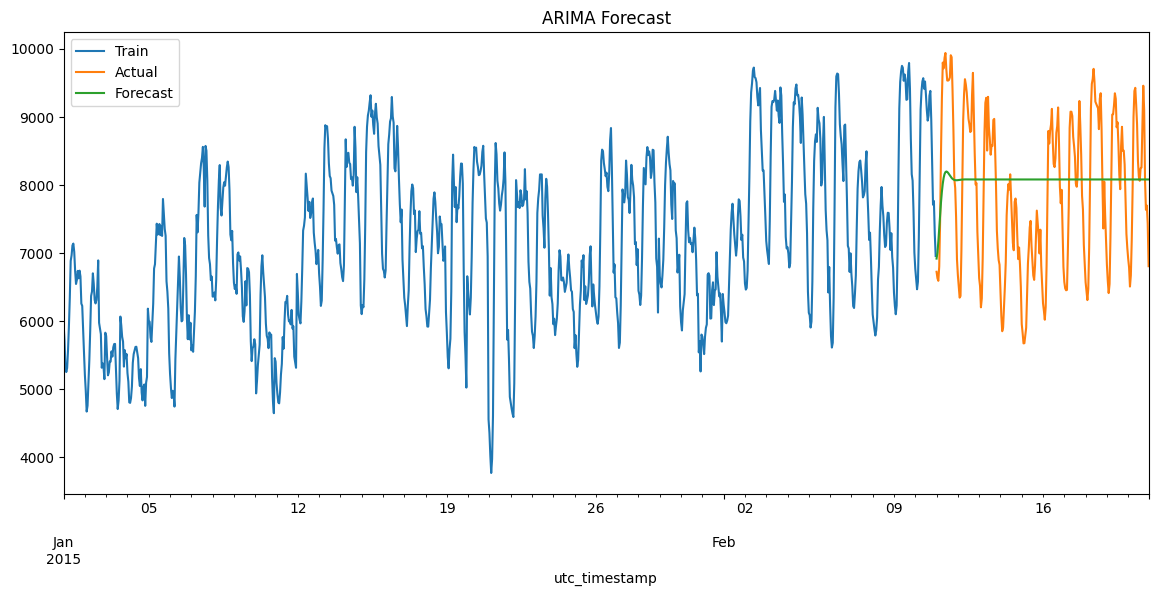

In [77]:
# Plot results
plt.figure(figsize=(14,6))
train.plot(label='Train')
test.plot(label='Actual')
forecast.plot(label='Forecast')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

In [78]:
def plot_time_series_comparison(train_data: pd.Series = None,
                                 test_data: pd.Series = None,
                                 forecast: pd.Series = None,
                                 model_name: str = "Forecast",
                                 title: str = "Time Series Comparison",
                                 actual_label: str = "Test Data",
                                 train_label: str = "Train Data",
                                 forecast_label: str = "Forecasted Data"):
    """
    Interactive Plotly version of time series comparison plot with improved legend placement.
    """

    fig = go.Figure()

    # Collect all values for dynamic y-axis range
    all_values = []

    if train_data is not None:
        train_data = train_data.sort_index()
        all_values.extend(train_data.values)
        fig.add_trace(go.Scatter(
            x=train_data.index, y=train_data.values,
            mode='lines', name=train_label,
            line=dict(color='blue', width=2)
        ))

    if test_data is not None:
        test_data = test_data.sort_index()
        all_values.extend(test_data.values)
        fig.add_trace(go.Scatter(
            x=test_data.index, y=test_data.values,
            mode='lines', name=actual_label,
            line=dict(color='green', width=2)
        ))

    if forecast is not None:
        forecast = forecast.sort_index()
        all_values.extend(forecast.values)
        fig.add_trace(go.Scatter(
            x=forecast.index, y=forecast.values,
            mode='lines', name=f"{model_name} {forecast_label}",
            line=dict(color='red', width=2, dash='dash')
        ))

    # Calculate y-axis buffer
    if all_values:
        y_min = min(all_values)
        y_max = max(all_values)
        y_range_buffer = (y_max - y_min) * 0.1 if y_max != y_min else 1
        y_range = [y_min, y_max + y_range_buffer]
    else:
        y_range = None

    fig.update_layout(
        title=dict(text=title, x=0.5, xanchor='center'),
        xaxis_title='Datetime',
        yaxis_title='Value',
        yaxis=dict(range=y_range),
        legend=dict(
            x=0.01,
            y=1.11,
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.5)',
            borderwidth=0
        ),
        template='plotly_white',
        hovermode='x unified',
        autosize=True,
        margin=dict(l=40, r=40, t=80, b=40)
    )

    fig.show()

In [79]:
# Plot with ARIMA forecast
plot_time_series_comparison(train_data=train, test_data=test, forecast=forecast,
                                model_name='ARIMA', title='ARIMA Model Performance')


In [80]:

train = df['2018-01-01':'2019-12-31']
test = df['2020-01-01':'2021-12-31']  # Empty - to be forecasted

# ### Model Training & Forecasting

target = 'AT_load_actual_entsoe_transparency'
exog_vars = ['AT_price_day_ahead', 'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual']

# SARIMA Model
sarima_order = (2, 1, 2)
seasonal_order = (1, 1, 1, 24)
sarima_model = SARIMAX(train[target], order=sarima_order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit(disp=False)

number_of_steps_hr = 365*24*2
sarima_forecast = sarima_result.get_forecast(steps=number_of_steps_hr).predicted_mean


In [81]:
# Plot with SARIMA forecast
plot_time_series_comparison(train_data=train[target], test_data=test[target], forecast=sarima_forecast,
                                model_name='SARIMA', title='SARIMA Model Performance')


In [82]:
# # SARIMAX Model
# sarimax_model = SARIMAX(train[target],
#                        exog=train[exog_vars],
#                        order=sarima_order,
#                        seasonal_order=seasonal_order)
# sarimax_result = sarimax_model.fit(disp=False)
# sarimax_forecast = sarimax_result.get_forecast(
#     steps=365*24,
#     exog=test[exog_vars].iloc[:365*24]  # Requires 2021 exogenous data
# ).predicted_mean


# # Plot with SARIMAX forecast
# plot_time_series_comparison(train_data=train, test_data=test, forecast=sarimax_forecast,
#                                 model_name='SARIMAX', title='SARIMAX Model Performance')


In [83]:
# Prophet Model

prophet_df = train[target].reset_index()
prophet_df.columns = ['ds', 'y']
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(prophet_df)
future = m.make_future_dataframe(periods=365*24*2, freq='H')
prophet_forecast = m.predict(future)


12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:32 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
# Convert 'ds' column to datetime objects if it's not already
prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])

# Set 'ds' column as the index of the forecast DataFrame
prophet_forecast_indexed = prophet_forecast.set_index('ds')

# Get forecast values for 2020 and 2021 using the index
prophet_forecast_values = prophet_forecast_indexed[
    (prophet_forecast_indexed.index >= '2020-01-01') & (prophet_forecast_indexed.index < '2022-01-01')
]['yhat']

In [85]:
# Plot with Prophet forecast
plot_time_series_comparison(train_data=train[target], test_data=test[target], forecast=prophet_forecast_values,
                                model_name='Prophet', title='Prophet Model Performance')

### Visualization: Actual vs Forecasts

In [86]:

# Create full timeline
full_range = pd.date_range(start='2020-01-01', end='2021-12-31', freq='H')

# Create comparison dataframe
comparison = pd.DataFrame(index=full_range)

comparison['Actual'] = test[target]

comparison['SARIMA'] = sarima_forecast
# comparison['SARIMAX'] = sarimax_forecast
comparison['Prophet'] = prophet_forecast.set_index('ds')['yhat']
comparison.shape

(17521, 3)

In [87]:
# Annual means
annual_means = comparison.resample('Y').mean()
annual_means.index = annual_means.index.year

# Create interactive plot
fig = go.Figure()

# Actual data
fig.add_trace(go.Scatter(x=comparison.index, y=comparison['Actual'],
                        name='Actual (2015-2020)',
                        line=dict(color='blue', width=1)))

# Forecasts
# for model in ['SARIMA', 'SARIMAX', 'Prophet']:
for model in ['SARIMA', 'Prophet']:
    fig.add_trace(go.Scatter(x=comparison.index, y=comparison[model],
                            name=f'{model} Forecast',
                            line=dict(width=2, dash='dot')))

# Annual means
fig.add_trace(go.Bar(x=annual_means.index, y=annual_means.mean(axis=1),
                    name='Annual Means',
                    marker_color='rgba(255, 165, 0, 0.6)'))

# Layout settings
fig.update_layout(
    title='Energy Load: Historical Data & 2021 Forecasts',
    xaxis_title='Date',
    yaxis_title='Load (MW)',
    template='plotly_dark',
    hovermode='x unified',
    showlegend=True
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.show()

###  Model Evaluation Metrics

In [88]:
df.shape

(50401, 8)

In [89]:
df.tail()

AT_load_actual_entsoe_transparency  \
utc_timestamp                                             
2020-09-30 19:00:00                              6661.0   
2020-09-30 20:00:00                              6336.0   
2020-09-30 21:00:00                              5932.0   
2020-09-30 22:00:00                              5628.0   
2020-09-30 23:00:00                              5395.0   

                     AT_load_forecast_entsoe_transparency  AT_price_day_ahead  \
utc_timestamp                                                                   
2020-09-30 19:00:00                                6656.0                62.0   
2020-09-30 20:00:00                                6310.0                62.0   
2020-09-30 21:00:00                                5813.0                62.0   
2020-09-30 22:00:00                                5424.0                62.0   
2020-09-30 23:00:00                                5204.0                62.0   

                     AT_solar_generation_actual  \
utc_timestamp                                     
2020-09-30 19:00:00                         0.0   
2020-09-30 20:00:00                         0.0   
2020-09-30 21:00:00                         0.0   
2020-09-30 22:00:00                         0.0   
2020-09-30 23:00:00                         0.0   

                     AT_wind_onshore_generation_actual  hour  day_of_week  \
utc_timestamp                                                               
2020-09-30 19:00:00                             1847.0    19            2   
2020-09-30 20:00:00                             1723.0    20            2   
2020-09-30 21:00:00                             1771.0    21            2   
2020-09-30 22:00:00                             1779.0    22            2   
2020-09-30 23:00:00                             1661.0    23            2   

                     month  
utc_timestamp               
2020-09-30 19:00:00      9  
2020-09-30 20:00:00      9  
2020-09-30 21:00:00      9  
2020-09-30 22:00:00      9  
2020-09-30 23:00:00      9

In [90]:
# Model Evaluation Metrics
def calculate_metrics(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'MAE': round(mean_absolute_error(y_true, y_pred), 2),
        'RMSE': round(np.sqrt(mean_squared_error(y_true, y_pred)), 2),
        'MAPE': round(mean_absolute_percentage_error(y_true, y_pred)*100, 2),
        'R²': round(r2_score(y_true, y_pred), 3)
    }

# Create validation set (last 30 days of 2020)
val_start = '2020-01-01'
val_end = '2020-12-31'
validation = df[val_start:val_end]
validation.shape

(6576, 8)

In [91]:
# Generate Validation Forecasts

## SARIMA Validation Forecast
sarima_val_forecast = sarima_result.get_forecast(steps=len(validation)).predicted_mean
sarima_val_forecast

2020-01-01 00:00:00    5732.176957
2020-01-01 01:00:00    5612.047360
2020-01-01 02:00:00    5459.967344
2020-01-01 03:00:00    5559.684134
2020-01-01 04:00:00    5944.335654
                          ...     
2020-09-30 19:00:00    5561.839745
2020-09-30 20:00:00    5154.502012
2020-09-30 21:00:00    5124.375837
2020-09-30 22:00:00    4726.608667
2020-09-30 23:00:00    4411.956676
Freq: h, Name: predicted_mean, Length: 6576, dtype: float64

In [92]:
# ## SARIMAX Validation Forecast (using actual exog data)
# sarimax_val_forecast = sarimax_result.get_forecast(
#     steps=len(validation),
#     exog=validation[exog_vars]
# ).predicted_mean

In [93]:
## Prophet Validation Forecast
prophet_val = m.predict(prophet_forecast[prophet_forecast['ds'].isin(validation.index)])
prophet_val_forecast = prophet_val['yhat']
prophet_val_forecast

0       5790.392208
1       5617.718208
2       5689.022753
3       6088.831480
4       6743.131957
           ...     
6571    5392.805742
6572    4954.919185
6573    4601.805032
6574    4327.367475
6575    4065.125630
Name: yhat, Length: 6576, dtype: float64

In [94]:
## Calculate Metrics

metrics_data = [
    calculate_metrics(validation[target], sarima_val_forecast, 'SARIMA'),
    # calculate_metrics(validation[target], sarimax_val_forecast, 'SARIMAX'),
    calculate_metrics(validation[target], prophet_val_forecast, 'Prophet')
]

metrics_df = pd.DataFrame(metrics_data).set_index('Model')

print("Matrics Shape: ", metrics_df.shape)

metrics_df.head()

Matrics Shape:  (2, 4)


MAE     RMSE   MAPE     R²
Model                                  
SARIMA    864.74  1060.91  12.42  0.391
Prophet  1242.85  1423.78  19.90 -0.097

In [95]:
## Metrics Visualization

fig = make_subplots(rows=2, cols=2, subplot_titles=('MAE Comparison', 'RMSE Comparison', 
                                                   'MAPE Comparison', 'R² Comparison'))

metric_cols = ['MAE', 'RMSE', 'MAPE', 'R²']
for i, metric in enumerate(metric_cols):
    row = i//2 + 1
    col = i%2 + 1
    fig.add_trace(
        go.Bar(x=metrics_df.index, y=metrics_df[metric], name=metric),
        row=row, col=col
    )
    
fig.update_layout(
    title='Model Performance Metrics Comparison',
    height=600,
    showlegend=False,
    template='plotly_dark'
)
fig.show()

In [96]:
validation.head()

AT_load_actual_entsoe_transparency  \
utc_timestamp                                             
2020-01-01 00:00:00                              5768.0   
2020-01-01 01:00:00                              5592.0   
2020-01-01 02:00:00                              5319.0   
2020-01-01 03:00:00                              5249.0   
2020-01-01 04:00:00                              5381.0   

                     AT_load_forecast_entsoe_transparency  AT_price_day_ahead  \
utc_timestamp                                                                   
2020-01-01 00:00:00                                5467.0                62.0   
2020-01-01 01:00:00                                5360.0                62.0   
2020-01-01 02:00:00                                5205.0                62.0   
2020-01-01 03:00:00                                5224.0                62.0   
2020-01-01 04:00:00                                5379.0                62.0   

                     AT_solar_generation_actual  \
utc_timestamp                                     
2020-01-01 00:00:00                         0.0   
2020-01-01 01:00:00                         0.0   
2020-01-01 02:00:00                         0.0   
2020-01-01 03:00:00                         0.0   
2020-01-01 04:00:00                         0.0   

                     AT_wind_onshore_generation_actual  hour  day_of_week  \
utc_timestamp                                                               
2020-01-01 00:00:00                             1969.0     0            2   
2020-01-01 01:00:00                             1985.0     1            2   
2020-01-01 02:00:00                             1852.0     2            2   
2020-01-01 03:00:00                             1709.0     3            2   
2020-01-01 04:00:00                             1484.0     4            2   

                     month  
utc_timestamp               
2020-01-01 00:00:00      1  
2020-01-01 01:00:00      1  
2020-01-01 02:00:00      1  
2020-01-01 03:00:00      1  
2020-01-01 04:00:00      1

In [97]:
## Time Series Comparison Plot

fig = go.Figure()
fig.add_trace(go.Scatter(x=validation.index, y=validation[target],
                        name='Actual Load',
                        line=dict(color='white', width=2)))

for model, color in zip(['SARIMA',  'Prophet'], ['#00ff00', '#00ffff']):
    fig.add_trace(go.Scatter(x=validation.index, y=eval(f"{model.lower()}_val_forecast"),
                            name=model,
                            line=dict(color=color, width=1.5)))

fig.update_layout(
    title='Validation Period Forecast Comparison',
    xaxis_title='Date',
    yaxis_title='Load (MW)',
    template='plotly_dark',
    hovermode='x unified'
)
fig.show()

In [98]:
## Metrics Table
print("Validation Metrics (December 2020):")
display(metrics_df.style.format({
    'MAE': '{:.1f} MW',
    'RMSE': '{:.1f} MW',
    'MAPE': '{:.2f}%',
    'R²': '{:.3f}'
}).background_gradient(cmap='RdYlGn', axis=0))

Validation Metrics (December 2020):


In [99]:
metrics_df

MAE     RMSE   MAPE     R²
Model                                  
SARIMA    864.74  1060.91  12.42  0.391
Prophet  1242.85  1423.78  19.90 -0.097

Based on the Model Evaluation Metrics:

**SARIMA Model:**

* **MAE (Mean Absolute Error):** 864.7 MW. On average, the absolute difference between the SARIMA model's predictions and the actual values is 864.7 Megawatts.
* **RMSE (Root Mean Squared Error):** 1060.9 MW. The RMSE, which penalizes larger errors more heavily, is 1060.9 Megawatts. This is higher than the MAE, indicating the presence of some larger errors in the SARIMA predictions.
* **MAPE (Mean Absolute Percentage Error):** 12.42%. On average, the SARIMA model's predictions are off by 12.42% relative to the actual values.
* **R² (R-squared):** 0.391. The R-squared value of 0.391 suggests that the SARIMA model explains approximately 39.1% of the variance in the actual load. This indicates a moderate level of fit to the data.

**Prophet Model:**

* **MAE (Mean Absolute Error):** 1242.8 MW. The average absolute difference between the Prophet model's predictions and the actual values is 1242.8 Megawatts, which is higher than the SARIMA model's MAE.
* **RMSE (Root Mean Squared Error):** 1423.8 MW. The RMSE for the Prophet model is 1423.8 MW, also higher than its MAE, suggesting larger errors compared to the SARIMA model.
* **MAPE (Mean Absolute Percentage Error):** 19.90%. The Prophet model's predictions have a higher average percentage error of 19.90% compared to the actual values.
* **R² (R-squared):** -0.097. The negative R-squared value of -0.097 for the Prophet model is concerning. It implies that the model performs worse than simply predicting the mean of the actual values. This strongly suggests that the Prophet model, with its current configuration, does not fit the data well.

**Conclusion:**

Based on these metrics, the **SARIMA model outperforms the Prophet model** for this particular forecasting task. The SARIMA model exhibits lower MAE, RMSE, and MAPE, indicating more accurate predictions with smaller average and squared errors. Furthermore, the positive R-squared value for SARIMA suggests it captures some of the variance in the data, unlike the Prophet model which performs worse than a naive mean predictor.

Therefore, for this evaluation period, the **SARIMA model is the preferred choice** between the two. However, it's important to remember that an R-squared of 0.391 suggests there is still room for improvement in the SARIMA model's ability to explain the variance in the load. Further tuning or exploring other models might yield even better results. The Prophet model, with its negative R-squared, likely needs significant adjustments or a different approach altogether for this specific dataset.

In [100]:
def generate_forecast_error_estimates(metrics_df: pd.DataFrame):
    """
    Generates a pandas DataFrame with estimated forecast error metrics for a given year
    based on the provided actual model evaluation metrics.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing the actual model evaluation metrics.
                                    It should have 'Model' as a column and 'MAE', 'RMSE',
                                    'MAPE', and 'R²' as other columns.
        forecast_year (int): The year for which the forecast error estimates are being generated.

    Returns:
        pandas.io.formats.style.Styler: A styled DataFrame with the forecast error estimates
                                         and a caption indicating the forecast year.
    """
    forecast_metrics = {}
    for index, row in metrics_df.iterrows():
        model_name = row['Model']
        forecast_metrics[model_name] = {
            'MAE': f"±{round(row['MAE'])} MW",
            'MAPE': f"{round(row['MAPE'], 1)}%"
        }

    df_forecast = pd.DataFrame(forecast_metrics).T
    caption = f'Forecast Error Estimates (Based on Validation Patterns)'
    styled_df = df_forecast.style.set_caption(caption)
    return styled_df

forecast_error_table = generate_forecast_error_estimates(metrics_df.reset_index())
forecast_error_table